<a href="https://colab.research.google.com/github/Benj-admin/MAP_X/blob/main/TP/TP02_Full_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP02 - Cross entropy loss and handwritten character recognition
In this practical, we will first **re-implement the cross entropy loss**, and then write our first proper **training and testing pipeline** for a **handwritten character recognition task** (small version of the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset).

**FYI:** GPUs are not necessary for this practical.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


# Part A - Reimplementing loss functions

## A.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [3]:
n_batch = 4
n_classes = 10
scores = torch.randn(n_batch, n_classes)
true_labels = torch.randint(0, n_classes, [n_batch])

cross_entropy = nn.CrossEntropyLoss()
log_loss = nn.NLLLoss()
softmax = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)

print("Method 1:", cross_entropy(scores, true_labels).item())
print("Method 2:", log_loss(log_softmax(scores), true_labels).item())
print("Method 3:", log_loss(torch.log(softmax(scores)), true_labels).item())


Method 1: 2.2444241046905518
Method 2: 2.2444241046905518
Method 3: 2.2444241046905518


## A.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [4]:
print("Method 4:", (-torch.mean(torch.log(torch.exp(torch.gather(scores,1,true_labels.unsqueeze(1)))/torch.sum(torch.exp(scores),1)))).item())

Method 4: 2.2444241046905518


## A.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [5]:
n_batch = 4
n_classes = 10
scores = 100*torch.randn(n_batch, n_classes)
true_labels = torch.randint(0, n_classes, [n_batch])

cross_entropy = nn.CrossEntropyLoss()
log_loss = nn.NLLLoss()
softmax = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)

print("Method 1:", cross_entropy(scores, true_labels).item())
print("Method 2:", log_loss(log_softmax(scores), true_labels).item())
print("Method 3:", log_loss(torch.log(softmax(scores)), true_labels).item())
print("Method 4:", (-torch.mean(torch.log(torch.exp(torch.gather(scores,1,true_labels.unsqueeze(1)))/torch.sum(torch.exp(scores),1)))).item())

Method 1: 144.80511474609375
Method 2: 144.80511474609375
Method 3: inf
Method 4: nan


Re-implement a stable version of cross-entropy.

In [6]:
scores_stable = scores - torch.max(scores,1,keepdim=True).values
print("Method 5:", (-torch.mean((torch.gather(scores_stable,1,true_labels.unsqueeze(1)))-torch.log(torch.sum(torch.exp(scores_stable),1)))).item())

Method 5: 144.8050994873047


# Part B - Handwritten character recognition

## B.0 - Dataloader
Import `load_digits` from `sklearn.datasets` (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)), load the corresponding dataset and extract the images, data (i.e. flattened version of the images) and targets (i.e. the labels).

In [22]:
from sklearn.datasets import load_digits
dataset = load_digits()
images = dataset.images
data = dataset.data
targets = dataset.target
X = torch.Tensor(data)
y = torch.LongTensor(targets)
X.shape

torch.Size([1797, 64])


Display the first image and its label.

tensor(0)

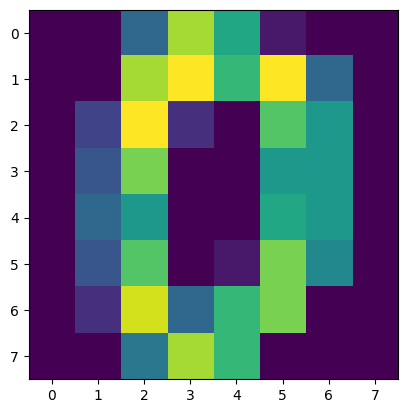

In [23]:
plt.imshow(images[0])
y[0]

Then, create two PyTorch datasets and dataloaders with a batch size of $50$ for this task: one for the train (80% of the dataset) and one for the test (remaining 20% of the dataset).

In [25]:

n_train = int(X.shape[0]*0.8)
n_test = X.shape[0] - n_train

index = list(range(X.shape[0]))
random.shuffle(index)

X = X[index]
y = y[index]

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers =2)

test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers =2)

## B.1 - Model creation

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [29]:
class MLP(nn.Module):
    def __init__(self, width, depth):
        super(MLP, self).__init__()
        if depth == 1:
            self.layers = nn.Linear(64,10)
        else:
            layers = [nn.Linear(64, width), nn.ReLU()]
            for _ in range(depth - 2):
                layers += [nn.Linear(width, width), nn.ReLU()]
            layers += [nn.Linear(width, 10)]
            self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

model = MLP(100,3)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


## B.2 - Loss and optimizer
Create a cross entropy loss.

In [31]:
loss = nn.CrossEntropyLoss(reduction = 'sum')

## B.3 - Training and testing loops
Finally, create the functions `train(model, epoch)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [ ]:
def train(model,epoch):


Train your model for 200 epochs and display the test loss and accuracy every 10 epochs.

In [ ]:
### YOUR CODE HERE ###

## B.4 - Analyze the results

Create a confusion matrix on the train and test datasets using `ConfusionMatrixDisplay.from_predictions` from `sklearn.metrics`. Which digits are confused?

In [ ]:
### YOUR CODE HERE ###

## B.5 - PCA and TSNE visualizations (optional)

To check wether the problem is easily to solve, plot the PCA and TSNE visualization of the dataset, where each digit corresponds to a different color. Are the digits/classes well separated?

In [ ]:
### YOUR CODE HERE ###

## B.6 - Model complexity (optional)
How many parameters does the model have? Are they necessary? Try different architectures, including a linear model (use `bias=False` in `nn.Linear` to remove the bias term).

In [ ]:
### YOUR CODE HERE ###